In [1]:
# Initialize used packages
import pandas as pd
import numpy as np
from Functions import gdx_to_dict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pybalmorel import MainResults
from Dictionaries import *


In [2]:
# Load GDX files
mainscenarios = ['syslim','natlim','carbtax']

symbolBal = ['G_CAP_YCRAF','CC_YCRAG','F_CONS_YCRA','OBJ_YCR','X_CAP_YCR','XH2_CAP_YCR','PRO_YCRAGF','XH2_FLOW_YCR','X_FLOW_YCR','EMI_YCRAG']

gams_directory = 'C:\\GAMS\\46'
file_path = 'C:\\Users\\tmad\\GitHub\\pap01_code\\files'
GDX_main = gdx_to_dict(symbolBal,mainscenarios,gams_directory,file_path)

c:\Users\tmad\GitHub\pap01_code\Functions.py:35: UserWarning: The GAMS version (46.2.0) differs from the API version (48.1.0).
  ws = gams.GamsWorkspace(system_directory=gams_sys_dir)


Finished, making dictionary of dataframes.



## Production plot

In [3]:
# Production preprocessing

prod = GDX_main['PRO_YCRAGF']
prod.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Commodity','level_7':'Technology','level_8':'Unit'},inplace=True)
flow_elec = GDX_main['X_FLOW_YCR']
flow_elec.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Export','level_3':'Import','level_4':'Unit'},inplace=True)
flow_h2 = GDX_main['XH2_FLOW_YCR']
flow_h2.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Export','level_3':'Import','level_4':'Unit'},inplace=True)

flow_elec = flow_elec.rename(columns={"Country": "C_EXP"})
flow_elec["C_IMP"] = flow_elec["Import"].map(locations)
flow_elec = flow_elec[flow_elec["C_EXP"] != flow_elec["C_IMP"]]
flow_elec.reset_index(inplace=True, drop=True)
flow_elec["Commodity"] = "ELECTRICITY"
flow_h2 = flow_h2.rename(columns={"Country": "C_EXP"})
flow_h2["C_IMP"] = flow_h2["Import"].map(locations)
flow_h2 = flow_h2[flow_h2["C_EXP"] != flow_h2["C_IMP"]]
flow_h2.reset_index(inplace=True, drop=True)
flow_h2["Commodity"] = "HYDROGEN"
flow = pd.concat([flow_elec, flow_h2], ignore_index=True)

prod_flow = pd.DataFrame(columns=prod.columns)

for i in range(len(flow_elec)):
    df_temp = pd.DataFrame([[flow.loc[i, "Year"],flow.loc[i, "C_EXP"], flow.loc[i,"Export"],\
                             "NA","TRANSMISSION","EXPORT",flow.loc[i,"Commodity"],"TRANSMISSION","TWh",\
                             -flow.loc[i,"Value"],flow.loc[i,"Scenario"]],\
                            [flow.loc[i,"Year"],flow.loc[i,"C_IMP"],flow.loc[i,"Import"],\
                             "NA","TRANSMISSION","IMPORT",flow.loc[i,"Commodity"],"TRANSMISSION","TWh",\
                            flow.loc[i,"Value"],flow.loc[i,"Scenario"]]],\
                           columns=prod.columns)
    prod_flow = pd.concat([prod_flow, df_temp], ignore_index=True)

prod= pd.concat([prod, prod_flow], ignore_index=True)

oil = ["FUELOIL", "LIGHTOIL"]
biomass = ["BIOOIL", "STRAW", "WOOD", "WOODWASTE", "WOODCHIPS", "WOODPELLETS","BIOGAS"]
other = ["DUMMY", "HEAT", "LNG", "OTHERGAS", "PEAT", "RETORTGAS", "SHALE","WASTEHEAT"]
coal = ["COAL","LIGNITE"]

# Remove storage
prod = prod[~prod['Technology'].str.contains('STORAGE')]
# heatsaving
prod.loc[prod['Generator'].str.contains('_HEATSAVINGS_'), 'Fuel'] = 'HEATSAVINGS'
# oil
prod['Fuel'] = prod['Fuel'].apply(lambda x: 'OIL' if x in oil else x)
# coal
prod['Fuel'] = prod['Fuel'].apply(lambda x: 'COAL & LIGNITE' if x in coal else x)
# biomass
prod['Fuel'] = prod['Fuel'].apply(lambda x: 'BIOMASS' if x in biomass else x)
# other
prod['Fuel'] = prod['Fuel'].apply(lambda x: 'OTHER' if x in other else x)
# wind
prod.loc[prod['Technology'].str.contains('-OFF'), 'Fuel'] = 'WIND-OFF'
prod.loc[prod['Technology'].str.contains('-ON'), 'Fuel'] = 'WIND-ON'
# CCS
prod.loc[((prod['Generator'].str.contains('CCS')) & (prod['Fuel'].str.contains('BIOMASS'))), 'Fuel'] = 'BIOMASS-CCS'
prod.loc[((prod['Generator'].str.contains('CCS')) & (prod['Fuel'].str.contains('NATGAS'))), 'Fuel'] = 'NATGAS-CCS'
#Heatpumps
HP = prod.copy()
HP = HP[HP['Generator'].str.contains("_HP_")]
HP["COP"] = HP["Generator"].str.extract(r'COP-(\d{3})', expand=False).astype(float) / 100
HP["ELEC"] = HP["Value"] / HP["COP"]
HP["AH"] = HP["Value"] - HP["ELEC"]
HP_elec = HP.copy()
HP_ambient = HP.copy()
HP_elec["Value"] = HP["ELEC"]
HP_ambient["Value"] = HP["AH"]
HP_ambient["Fuel"] = "AMBIENT HEAT"
HP.drop(columns=["COP", "ELEC", "AH"], inplace=True)
HP_elec.drop(columns=["COP", "ELEC", "AH"], inplace=True)
HP_ambient.drop(columns=["COP", "ELEC", "AH"], inplace=True)

HP = pd.concat([HP_elec, HP_ambient], ignore_index=True)
# Remove all rows containing heatpumps from prod
prod = prod[~prod['Generator'].str.contains('_HP_')]
# Concatenate the new HP dataframe
prod = pd.concat([prod, HP], ignore_index=True)

# Rename fuels using the fuels dictionary
prod['Fuel'] = prod['Fuel'].map(fuels).fillna(prod['Fuel'])
prod['Commodity'] = prod['Commodity'].map(commodities).fillna(prod['Commodity'])

prod_elec = prod[(prod['Commodity'] == 'Electricity') & (prod['Technology'] != 'TRANSMISSION')]
prod_heat = prod[(prod['Commodity'] == 'Heat') & (prod['Technology'] != 'TRANSMISSION')]
prod_h2 = prod[(prod['Commodity'] == 'H2') & (prod['Technology'] != 'TRANSMISSION')]

prod_elec.set_index(['Year','Country','Region','Area','Generator', 'Fuel','Commodity', 'Technology','Unit','Scenario'], inplace=True)
prod_heat.set_index(['Year','Country','Region','Area','Generator', 'Fuel','Commodity', 'Technology','Unit','Scenario'], inplace=True)
prod_h2.set_index(['Year','Country','Region','Area','Generator', 'Fuel','Commodity', 'Technology','Unit','Scenario'], inplace=True)

prod_elec_grouped = prod_elec.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack()
prod_heat_grouped = prod_heat.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack()
prod_h2_grouped = prod_h2.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack()

# Fuel order
order_elec = ["Coal & lignite","Oil","Other","Nuclear","Natgas","Natgas, CCS","Muniwaste","Biomass","Biomass, CCS","Hydrogen", "Hydro", "Solar","Onshore wind", "Offshore wind"]
order_heat = ["Coal & lignite","Oil","Other","Natgas","Natgas, CCS","Muniwaste","Biomass","Biomass, CCS", "Electric", "Ambient heat","Solar", "Heatsavings"]
order_h2 = ["Natgas","Natgas, CCS", "Electric","Import, H2"]

prod_elec_grouped = prod_elec_grouped[order_elec]
prod_heat_grouped = prod_heat_grouped[order_heat]
prod_h2_grouped = prod_h2_grouped[order_h2]

# Scenario order
order_scenario = mainscenarios
prod_elec_grouped = prod_elec_grouped.reindex(order_scenario, level=1)
prod_heat_grouped = prod_heat_grouped.reindex(order_scenario, level=1)
prod_h2_grouped = prod_h2_grouped.reindex(order_scenario, level=1)

# Ordered list of colors
colors_elec = [color_mapping[fuel] for fuel in order_elec]
colors_heat = [color_mapping[fuel] for fuel in order_heat]
colors_h2 = [color_mapping[fuel] for fuel in order_h2]

# Rename scenario labels
prod_elec_grouped.rename(index=scenario_names, level=1, inplace=True)
prod_heat_grouped.rename(index=scenario_names, level=1, inplace=True)
prod_h2_grouped.rename(index=scenario_names, level=1, inplace=True)

#prod_elec_grouped.drop('2025', level=0, inplace=True)
#prod_heat_grouped.drop('2025', level=0, inplace=True)
#prod_h2_grouped.drop('2025', level=0, inplace=True)

C:\Users\tmad\AppData\Local\Temp\ipykernel_13872\1619867204.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prod_flow = pd.concat([prod_flow, df_temp], ignore_index=True)


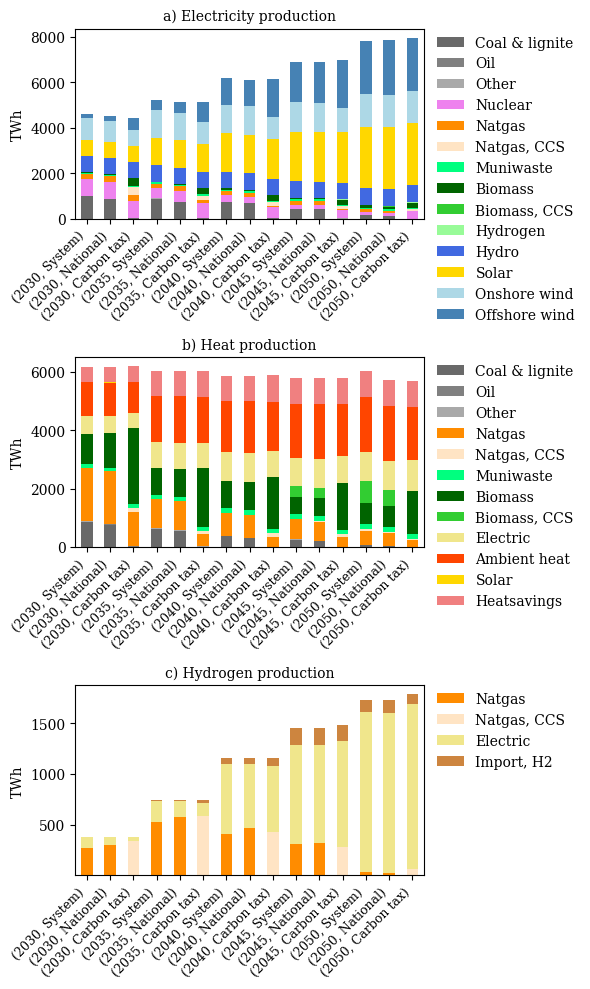

In [4]:
# Do the plotting
plt.rcParams["font.family"] = "serif"

# Figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))

# Plot Electricity Production
prod_elec_grouped.plot(kind='bar', stacked=True, color=colors_elec, ax=axes[0])
axes[0].set_title('a) Electricity production', fontsize=10)
axes[0].set_ylabel('TWh')
axes[0].set_xlabel('')
axes[0].legend(title='', bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10)

# Plot Heat Production
prod_heat_grouped.plot(kind='bar', stacked=True, color=colors_heat, ax=axes[1])
axes[1].set_title('b) Heat production', fontsize=10)
axes[1].set_ylabel('TWh')
axes[1].set_xlabel('')
axes[1].legend(title='',bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10)

# Plot Hydrogen Production
prod_h2_grouped.plot(kind='bar', stacked=True, color=colors_h2, ax=axes[2])
axes[2].set_title('c) Hydrogen production', fontsize=10)
axes[2].set_ylabel('TWh')
axes[2].set_xlabel('')
axes[2].legend(title='',bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10)

# Reduce the font size of the x axis
for ax in axes:
    ax.tick_params(axis='x', labelsize=9)

    # Tilt the x axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
plt.show()


## EMI plot

C:\Users\tmad\AppData\Local\Temp\ipykernel_8536\3046360646.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['{:.0%}'.format(x) for x in axes[0].get_xticks()])
C:\Users\tmad\AppData\Local\Temp\ipykernel_8536\3046360646.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['{:.0%}'.format(x) for x in axes[1].get_xticks()])


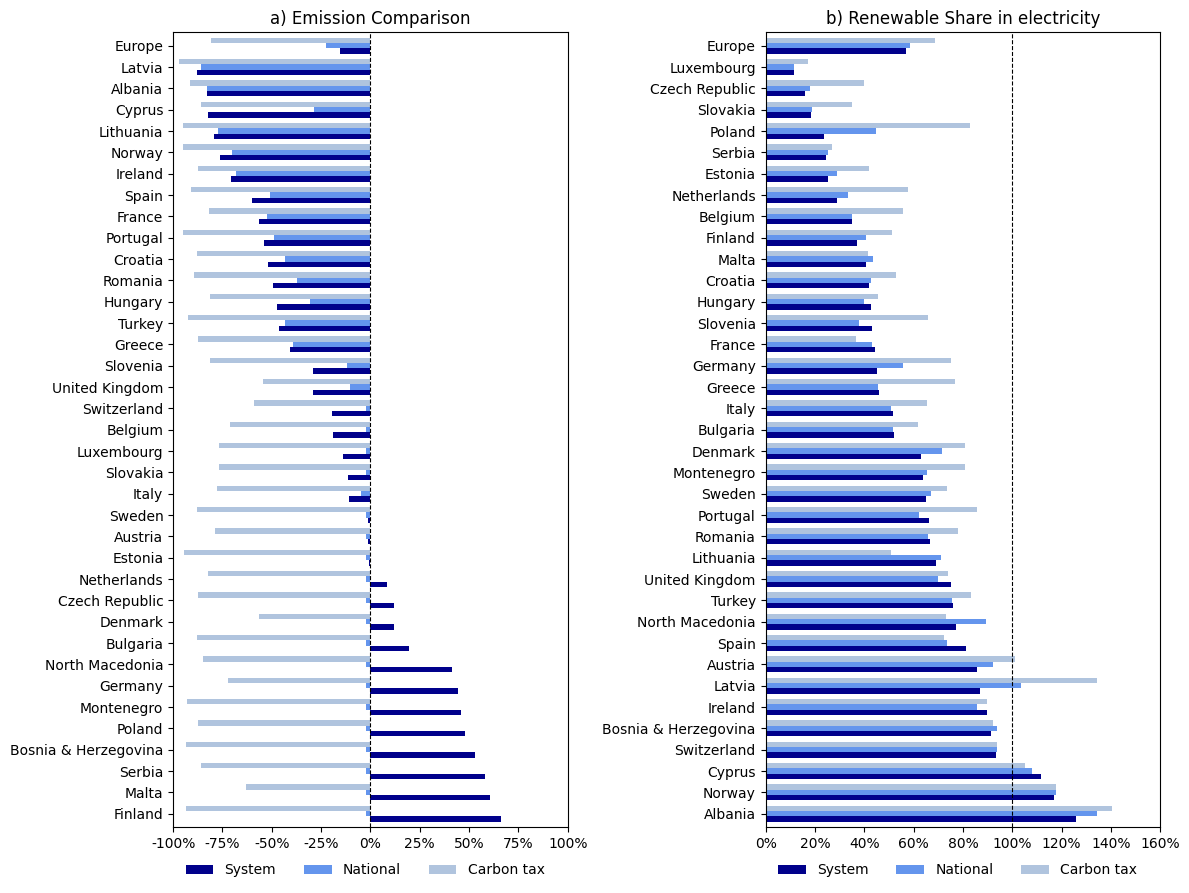

In [5]:
# Emission comparison

emi = GDX_main['EMI_YCRAG']
emi.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
emi = emi[(emi['Year']=='2030')]
emi_grouped = emi.groupby(['Country','Scenario'])['Value'].sum().unstack()*1e3 # ton
emi_grouped.rename(index=change_country_label, inplace=True)
emi_grouped = emi_grouped[order_scenario]
emi_grouped = emi_grouped.sub(pd.Series(country_budgets), axis=0)
emi_store = emi_grouped.copy()
emi_store.sort_values(by='syslim', ascending=False, inplace=True)
emi_grouped = emi_grouped.div(pd.Series(country_budgets), axis=0)
emi_grouped.sort_values(by='syslim', ascending=False, inplace=True)
emi_grouped.rename(columns=scenario_names, inplace=True)
emi_grouped2 = emi.groupby(['Unit','Scenario'])['Value'].sum().unstack()*1e3 # ton
emi_grouped2 = emi_grouped2[order_scenario]
country_budgets_total = pd.Series(country_budgets).sum()
emi_grouped2 = emi_grouped2.sub(country_budgets_total, axis=0)
emi_grouped2 = emi_grouped2.div(country_budgets_total, axis=0)
emi_grouped2.rename(columns=scenario_names, inplace=True)
emi_grouped = pd.concat([emi_grouped, emi_grouped2], axis=0)
emi_grouped.rename(index={'kton': 'Europe'}, inplace=True)

prod_2030 = prod[(prod['Year'] == '2030') & (prod['Commodity'] == 'Electricity')]
prod_2030_renewables = prod_2030[prod_2030['Fuel'].isin(renewable_fuels)]
prod_2030_total = prod_2030.groupby(['Country','Scenario'])['Value'].sum().unstack()
prod_2030_renewables_total = prod_2030_renewables.groupby(['Country','Scenario'])['Value'].sum().unstack()
renewable_share_2030 = prod_2030_renewables_total.div(prod_2030_total)
renewable_share_2030 = renewable_share_2030[order_scenario]
renewable_share_2030.sort_values(by='syslim', ascending=False, inplace=True)
renewable_share_2030.rename(index=change_country_label, inplace=True)
renewable_share_2030.rename(columns=scenario_names, inplace=True)
prod_2030_total_EU = prod_2030_total.sum()
prod_2030_renewables_total_EU = prod_2030_renewables_total.sum()
renewable_share_2030_EU = prod_2030_renewables_total_EU.div(prod_2030_total_EU)
renewable_share_2030_EU = renewable_share_2030_EU[order_scenario]
renewable_share_2030_EU.rename(index=scenario_names, inplace=True)
renewable_share_2030.loc['Europe'] = renewable_share_2030_EU


colors_scenario = [color_mapping2[scenario] for scenario in order_scenario]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))

# Plot Emission Comparison
emi_grouped.plot(kind='barh', stacked=False, ax=axes[0], color=colors_scenario, width=0.75)
axes[0].legend(title='', bbox_to_anchor=(0, -0.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10, ncols=3)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_xlim(-1, 1)
axes[0].set_xticklabels(['{:.0%}'.format(x) for x in axes[0].get_xticks()])
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8, zorder=1)
axes[0].set_title('a) Emission Comparison')

# Plot Renewable Share
renewable_share_2030.plot(kind='barh', stacked=False, ax=axes[1], color=colors_scenario, width=0.75)
axes[1].legend(title='', bbox_to_anchor=(0, -0.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10, ncols=3)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim(0, 1.6)
axes[1].set_xticklabels(['{:.0%}'.format(x) for x in axes[1].get_xticks()])
axes[1].axvline(x=1, color='black', linestyle='--', linewidth=0.8, zorder=1)
axes[1].set_title('b) Renewable Share in electricity')



plt.tight_layout()
for ax in axes:
    #ax.tick_params(axis='y', labelsize=10)
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

plt.show()

## OBJ plot

C:\Users\tmad\AppData\Local\Temp\ipykernel_19832\1240866485.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['Category'] = obj['Category'].map(categories)


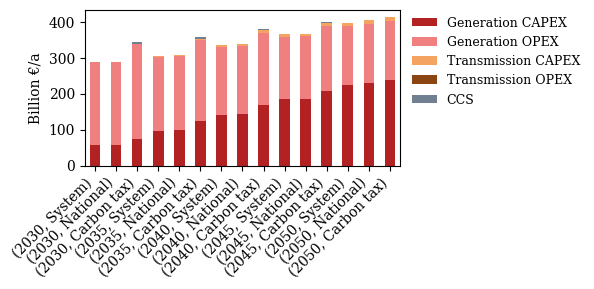

Category         Generation CAPEX  Generation OPEX  Transmission CAPEX  \
Year Scenario                                                            
2030 System             56.964337       230.283614            0.072457   
     National           58.298196       230.891625            0.095357   
     Carbon tax         73.617704       263.918747            0.058805   
2035 System             96.610262       205.309739            2.529875   
     National           97.513147       206.145716            2.628915   
     Carbon tax        124.261095       224.035341            5.051480   
2040 System            141.509644       188.978419            4.145606   
     National          142.006237       191.273085            4.463144   
     Carbon tax        168.869181       200.901547            7.363809   
2045 System            184.275307       174.241792            6.175892   
     National          185.373393       175.118750            6.576192   
     Carbon tax        206.198018     

In [ ]:
# Plot the objective function

obj = GDX_main['OBJ_YCR']
obj.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Category','level_4':'Unit'},inplace=True)

obj = obj[obj['Category'] != 'GENERATION_CO2_TAX']
obj['Category'] = obj['Category'].map(categories)
obj_grouped = obj.groupby(['Year','Scenario','Category'])['Value'].sum().unstack()/1e3
obj_grouped = obj_grouped.reindex(order_scenario, level=1)
obj_grouped.rename(index=scenario_names, level=1, inplace=True)

order_categories = ['Generation CAPEX','Generation OPEX','Transmission CAPEX','Transmission OPEX','CCS']
obj_grouped = obj_grouped[order_categories]
color_categories = [color_mapping[category] for category in order_categories]

fig, ax = plt.subplots(figsize=(6, 3))
obj_grouped.plot(kind='bar', stacked=True, ax=ax, color=color_categories)
ax.legend(title='',bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=9)
#ax.set_title('Objective Function', fontsize=10)
ax.set_ylabel('Billion €/a')
ax.set_xlabel('')
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
plt.tight_layout()
plt.show()


## EMI plot 2

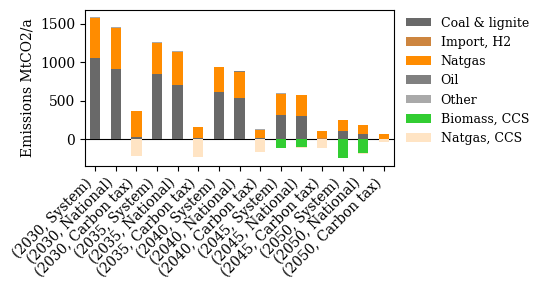

In [7]:
emi2 = GDX_main['EMI_YCRAG']
emi2.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
cc = GDX_main['CC_YCRAG']
cc.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
other = ["DUMMY", "HEAT", "LNG", "OTHERGAS", "PEAT", "RETORTGAS", "SHALE","WASTEHEAT"]
oil = ["FUELOIL", "LIGHTOIL"]
biomass = ["BIOOIL", "STRAW", "WOOD", "WOODWASTE", "WOODCHIPS", "WOODPELLETS","BIOGAS"]
emi2['Fuel'] = emi2['Fuel'].apply(lambda x: 'OTHER' if x in other else x)
emi2['Fuel'] = emi2['Fuel'].apply(lambda x: 'OIL' if x in oil else x)
emi2['Fuel'] = emi2['Fuel'].map(fuels).fillna(emi2['Fuel'])

cc['Fuel'] = cc['Fuel'].apply(lambda x: 'BIOMASS-CCS' if x in biomass else x)
cc['Fuel'] = cc['Fuel'].apply(lambda x: 'NATGAS-CCS' if x in ["NATGAS"] else x)
cc['Fuel'] = cc['Fuel'].map(fuels).fillna(cc['Fuel'])

emi_grouped2 = emi2.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack() /1e3 # Mton
cc_grouped = cc.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack() /-1e3 # Mton
emi_cc_combined = pd.concat([emi_grouped2, cc_grouped], axis=1)
emi_cc_combined = emi_cc_combined.reindex(order_scenario, level=1)
emi_cc_combined.rename(index=scenario_names, level=1, inplace=True)



#emi_cc_combined = emi_cc_combined[order_scenario]

# Define colors for each fuel
fuel_colors = {fuel: color_mapping[fuel] for fuel in emi_cc_combined.columns}


fig, ax = plt.subplots(figsize=(5.5, 3))
emi_cc_combined.plot(kind='bar', stacked=True, ax=ax, color=[fuel_colors[fuel] for fuel in emi_cc_combined.columns])
ax.legend(title='',bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=9)
#ax.set_title('Objective Function', fontsize=10)
ax.set_ylabel('Emissions MtCO2/a')
ax.axhline(y=0, color='black', linewidth=0.8, zorder=0)
ax.set_xlabel('')
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
plt.tight_layout()
plt.show()



## Country plot

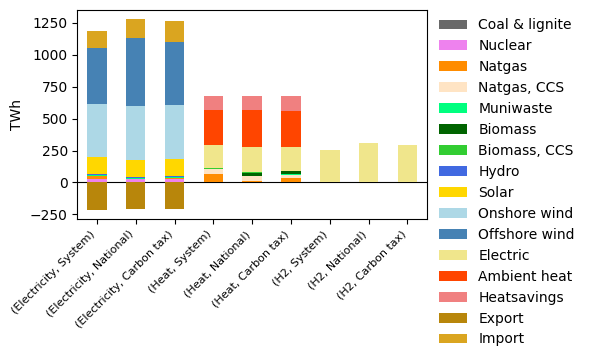

In [6]:
# Make country specific production plot
# (Run the first bit of cells first to get the "prod" dataframe)

Country = 'UNITED_KINGDOM'

prod_c = prod[(prod['Country'] == Country) & (prod['Year'] == '2050')]
prod_c_grouped = prod_c.groupby(['Commodity','Scenario','Fuel'])['Value'].sum().unstack()

# Reorder columns according to order_combined, ignoring missing columns
order_combined = list(dict.fromkeys(order_elec + order_heat + order_h2 + ["Export", "Import"]))
prod_c_grouped = prod_c_grouped.reindex(columns=[col for col in order_combined if col in prod_c_grouped.columns])
prod_c_grouped = prod_c_grouped.reindex(["Electricity", "Heat", "H2"], level=0)
prod_c_grouped = prod_c_grouped.reindex(mainscenarios, level=1)
color_c = [color_mapping[fuel] for fuel in prod_c_grouped.columns]
prod_c_grouped.rename(index=scenario_names, level=1, inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3.5))
prod_c_grouped.plot(kind='bar', stacked=True, ax=axes, color=color_c)
axes.legend(title='',bbox_to_anchor=(1.0, 1.02), loc='upper left', frameon=False, edgecolor='black', fontsize=10)
axes.axhline(y=0, color='black', linewidth=0.8, zorder=0)
#axes.set_title('Production in Romania', fontsize=10)
axes.set_ylabel('TWh')
axes.set_xlabel('')
axes.tick_params(axis='x', labelsize=8)
for label in axes.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()
plt.show()


## Production plot 2 -- H2 sens

In [11]:
# Load GDX files
mainscenarios2 = ['syslim','H075','H050','H025','H000']

symbolBal2 = ['PRO_YCRAGF','EMI_YCRAG','CC_YCRAG','F_CONS_YCRA']

gams_directory = 'C:\\GAMS\\46'
file_path = 'C:\\Users\\tmad\\GitHub\\pap01_code\\files'
GDX_main = gdx_to_dict(symbolBal2,mainscenarios2,gams_directory,file_path)

c:\Users\tmad\GitHub\pap01_code\Functions.py:35: UserWarning: The GAMS version (46.2.0) differs from the API version (48.1.0).
  ws = gams.GamsWorkspace(system_directory=gams_sys_dir)


Finished, making dictionary of dataframes.



In [12]:
# Production preprocessing

prod = GDX_main['PRO_YCRAGF']
prod.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Commodity','level_7':'Technology','level_8':'Unit'},inplace=True)

oil = ["FUELOIL", "LIGHTOIL"]
biomass = ["BIOOIL", "STRAW", "WOOD", "WOODWASTE", "WOODCHIPS", "WOODPELLETS","BIOGAS"]
other = ["DUMMY", "HEAT", "LNG", "OTHERGAS", "PEAT", "RETORTGAS", "SHALE","WASTEHEAT"]
coal = ["COAL","LIGNITE"]

# Remove storage
prod = prod[~prod['Technology'].str.contains('STORAGE')]
# heatsaving
prod.loc[prod['Generator'].str.contains('_HEATSAVINGS_'), 'Fuel'] = 'HEATSAVINGS'
# oil
prod['Fuel'] = prod['Fuel'].apply(lambda x: 'OIL' if x in oil else x)
# coal
prod['Fuel'] = prod['Fuel'].apply(lambda x: 'COAL & LIGNITE' if x in coal else x)
# biomass
prod['Fuel'] = prod['Fuel'].apply(lambda x: 'BIOMASS' if x in biomass else x)
# other
prod['Fuel'] = prod['Fuel'].apply(lambda x: 'OTHER' if x in other else x)
# wind
prod.loc[prod['Technology'].str.contains('-OFF'), 'Fuel'] = 'WIND-OFF'
prod.loc[prod['Technology'].str.contains('-ON'), 'Fuel'] = 'WIND-ON'
# CCS
prod.loc[((prod['Generator'].str.contains('CCS')) & (prod['Fuel'].str.contains('BIOMASS'))), 'Fuel'] = 'BIOMASS-CCS'
prod.loc[((prod['Generator'].str.contains('CCS')) & (prod['Fuel'].str.contains('NATGAS'))), 'Fuel'] = 'NATGAS-CCS'

#Heatpumps
HP = prod.copy()
HP = HP[HP['Generator'].str.contains("_HP_")]
HP["COP"] = HP["Generator"].str.extract(r'COP-(\d{3})', expand=False).astype(float) / 100
HP["ELEC"] = HP["Value"] / HP["COP"]
HP["AH"] = HP["Value"] - HP["ELEC"]
HP_elec = HP.copy()
HP_ambient = HP.copy()
HP_elec["Value"] = HP["ELEC"]
HP_ambient["Value"] = HP["AH"]
HP_ambient["Fuel"] = "AMBIENT HEAT"
HP.drop(columns=["COP", "ELEC", "AH"], inplace=True)
HP_elec.drop(columns=["COP", "ELEC", "AH"], inplace=True)
HP_ambient.drop(columns=["COP", "ELEC", "AH"], inplace=True)

HP = pd.concat([HP_elec, HP_ambient], ignore_index=True)
# Remove all rows containing heatpumps from prod
prod = prod[~prod['Generator'].str.contains('_HP_')]
# Concatenate the new HP dataframe
prod = pd.concat([prod, HP], ignore_index=True)

# Rename fuels using the fuels dictionary
prod['Fuel'] = prod['Fuel'].map(fuels).fillna(prod['Fuel'])
prod['Commodity'] = prod['Commodity'].map(commodities).fillna(prod['Commodity'])

prod_elec = prod[(prod['Commodity'] == 'Electricity') & (prod['Technology'] != 'TRANSMISSION')]
prod_heat = prod[(prod['Commodity'] == 'Heat') & (prod['Technology'] != 'TRANSMISSION')]
prod_h2 = prod[(prod['Commodity'] == 'H2') & (prod['Technology'] != 'TRANSMISSION')]

prod_elec.set_index(['Year','Country','Region','Area','Generator', 'Fuel','Commodity', 'Technology','Unit','Scenario'], inplace=True)
prod_heat.set_index(['Year','Country','Region','Area','Generator', 'Fuel','Commodity', 'Technology','Unit','Scenario'], inplace=True)
prod_h2.set_index(['Year','Country','Region','Area','Generator', 'Fuel','Commodity', 'Technology','Unit','Scenario'], inplace=True)

prod_elec_grouped = prod_elec.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack()
prod_heat_grouped = prod_heat.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack()
prod_h2_grouped = prod_h2.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack()

# Fuel order
order_elec = ["Coal & lignite","Oil","Other","Nuclear","Natgas","Muniwaste","Biomass","Hydrogen", "Hydro", "Solar","Onshore wind", "Offshore wind"]
order_heat = ["Coal & lignite","Oil","Other","Natgas","Natgas, CCS","Muniwaste","Biomass","Biomass, CCS", "Electric", "Ambient heat","Solar", "Heatsavings"]
order_h2 = ["Natgas","Natgas, CCS", "Electric","Import, H2"]

prod_elec_grouped = prod_elec_grouped[order_elec]
prod_heat_grouped = prod_heat_grouped[order_heat]
prod_h2_grouped = prod_h2_grouped[order_h2]

# Scenario order
order_scenario = mainscenarios2
prod_elec_grouped = prod_elec_grouped.reindex(order_scenario, level=1)
prod_heat_grouped = prod_heat_grouped.reindex(order_scenario, level=1)
prod_h2_grouped = prod_h2_grouped.reindex(order_scenario, level=1)

# Ordered list of colors
colors_elec = [color_mapping[fuel] for fuel in order_elec]
colors_heat = [color_mapping[fuel] for fuel in order_heat]
colors_h2 = [color_mapping[fuel] for fuel in order_h2]

# Rename scenario labels
prod_elec_grouped.rename(index=scenario_names, level=1, inplace=True)
prod_heat_grouped.rename(index=scenario_names, level=1, inplace=True)
prod_h2_grouped.rename(index=scenario_names, level=1, inplace=True)

C:\Users\tmad\AppData\Local\Temp\ipykernel_11040\4168103227.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod['Fuel'] = prod['Fuel'].apply(lambda x: 'OIL' if x in oil else x)
C:\Users\tmad\AppData\Local\Temp\ipykernel_11040\4168103227.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod['Fuel'] = prod['Fuel'].apply(lambda x: 'COAL & LIGNITE' if x in coal else x)
C:\Users\tmad\AppData\Local\Temp\ipykernel_11040\4168103227.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

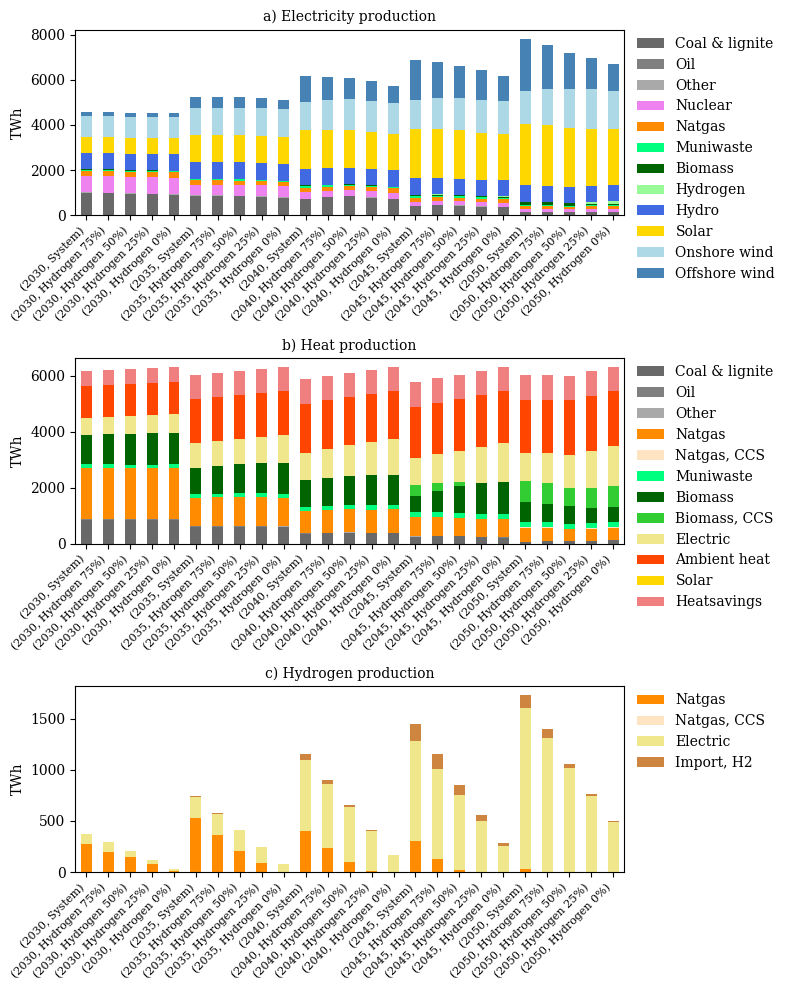

In [13]:
# Do the plotting
plt.rcParams["font.family"] = "serif"

# Figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

# Plot Electricity Production
prod_elec_grouped.plot(kind='bar', stacked=True, color=colors_elec, ax=axes[0])
axes[0].set_title('a) Electricity production', fontsize=10)
axes[0].set_ylabel('TWh')
axes[0].set_xlabel('')
axes[0].legend(title='', bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10)

# Plot Heat Production
prod_heat_grouped.plot(kind='bar', stacked=True, color=colors_heat, ax=axes[1])
axes[1].set_title('b) Heat production', fontsize=10)
axes[1].set_ylabel('TWh')
axes[1].set_xlabel('')
axes[1].legend(title='',bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10)

# Plot Hydrogen Production
prod_h2_grouped.plot(kind='bar', stacked=True, color=colors_h2, ax=axes[2])
axes[2].set_title('c) Hydrogen production', fontsize=10)
axes[2].set_ylabel('TWh')
axes[2].set_xlabel('')
axes[2].legend(title='',bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10)

# Reduce the font size of the x axis
for ax in axes:
    ax.tick_params(axis='x', labelsize=8)

    # Tilt the x axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
plt.show()

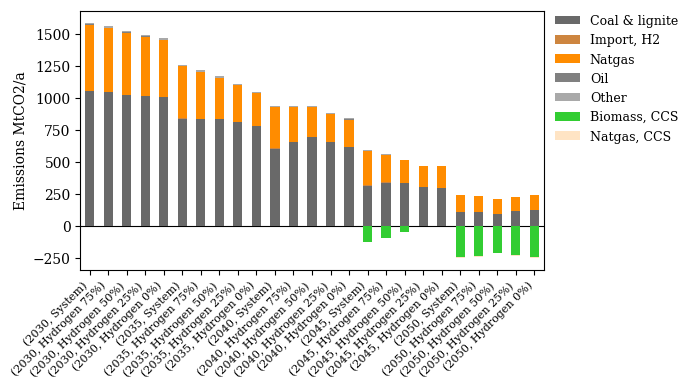

In [21]:
# Emission comparison
#emi = GDX_main['EMI_YCRAG']
#emi.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
#emi = emi[(emi['Year']=='2030')]
#emi_grouped = emi.groupby(['Country','Scenario'])['Value'].sum().unstack()*1e3
#emi_grouped.rename(index=change_country_label, inplace=True)
#order_scenario = mainscenarios2
#emi_grouped = emi_grouped[order_scenario]
#emi_grouped = emi_grouped.sub(pd.Series(country_budgets), axis=0)
#emi_grouped = emi_grouped.div(pd.Series(country_budgets), axis=0)
#emi_grouped.sort_values(by='syslim', ascending=False, inplace=True)
#emi_grouped.rename(columns=scenario_names, inplace=True)

#colors_scenario = [color_mapping2[scenario] for scenario in order_scenario]

#fig, axes = plt.subplots(figsize=(5, 10))

# Plot Emission Comparison
#emi_grouped.plot(kind='barh', stacked=False, ax=axes, color=colors_scenario)
#axes.legend(title='', bbox_to_anchor=(0, -0.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10, ncols=3)
#axes.set_xlabel('')
#axes.set_ylabel('')
#axes.set_xlim(-1, 1)
#axes.set_xticklabels(['{:.0%}'.format(x) for x in axes.get_xticks()])
#axes.axvline(x=0, color='black', linestyle='--', linewidth=0.8, zorder=0)
#axes.set_title('a) Emission Comparison')

#plt.tight_layout()
#plt.show()

emisens = GDX_main['EMI_YCRAG']
emisens.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
ccsens = GDX_main['CC_YCRAG']
ccsens.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
other = ["DUMMY", "HEAT", "LNG", "OTHERGAS", "PEAT", "RETORTGAS", "SHALE","WASTEHEAT"]
oil = ["FUELOIL", "LIGHTOIL"]
biomass = ["BIOOIL", "STRAW", "WOOD", "WOODWASTE", "WOODCHIPS", "WOODPELLETS","BIOGAS"]
emisens['Fuel'] = emisens['Fuel'].apply(lambda x: 'OTHER' if x in other else x)
emisens['Fuel'] = emisens['Fuel'].apply(lambda x: 'OIL' if x in oil else x)
emisens['Fuel'] = emisens['Fuel'].map(fuels).fillna(emisens['Fuel'])

ccsens['Fuel'] = ccsens['Fuel'].apply(lambda x: 'BIOMASS-CCS' if x in biomass else x)
ccsens['Fuel'] = ccsens['Fuel'].apply(lambda x: 'NATGAS-CCS' if x in ["NATGAS"] else x)
ccsens['Fuel'] = ccsens['Fuel'].map(fuels).fillna(ccsens['Fuel'])

emisens_grouped = emisens.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack() /1e3 # Mton
ccsens_grouped = ccsens.groupby(['Year','Scenario','Fuel'])['Value'].sum().unstack() /-1e3 # Mton
emi_cc_combined = pd.concat([emisens_grouped, ccsens_grouped], axis=1)
emi_cc_combined = emi_cc_combined.reindex(order_scenario, level=1)
emi_cc_combined.rename(index=scenario_names, level=1, inplace=True)



#emi_cc_combined = emi_cc_combined[order_scenario]

# Define colors for each fuel
fuel_colors = {fuel: color_mapping[fuel] for fuel in emi_cc_combined.columns}


fig, ax = plt.subplots(figsize=(7, 4))
emi_cc_combined.plot(kind='bar', stacked=True, ax=ax, color=[fuel_colors[fuel] for fuel in emi_cc_combined.columns])
ax.legend(title='',bbox_to_anchor=(1.0, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=9)
#ax.set_title('Objective Function', fontsize=10)
ax.set_ylabel('Emissions MtCO2/a')
ax.tick_params(axis='x', labelsize=8)
ax.axhline(y=0, color='black', linewidth=0.8, zorder=0)
ax.set_xlabel('')
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
plt.tight_layout()
plt.show()


## Cost 2 - sens

In [2]:
# Load GDX files
mainscenarios3 = ['syslim','c50','c100','c150','c200','carbtax','c300']

symbolBal3 = ['OBJ_YCR','EMI_YCRAG','CC_YCRAG']

gams_directory = 'C:\\GAMS\\46'
file_path = 'C:\\Users\\tmad\\GitHub\\pap01_code\\files'
GDX_main = gdx_to_dict(symbolBal3,mainscenarios3,gams_directory,file_path)

c:\Users\tmad\GitHub\pap01_code\Functions.py:35: UserWarning: The GAMS version (46.2.0) differs from the API version (48.1.0).
  ws = gams.GamsWorkspace(system_directory=gams_sys_dir)


Finished, making dictionary of dataframes.



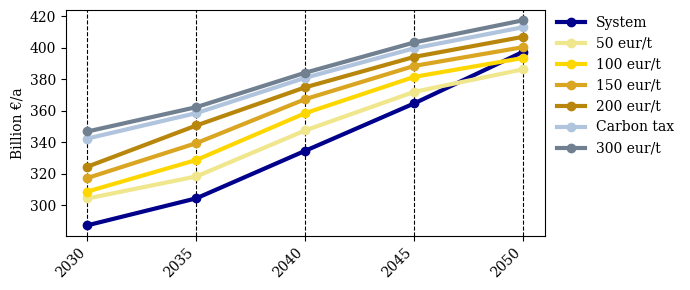

In [22]:
# Plot the objective function

obj = GDX_main['OBJ_YCR']
obj.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Category','level_4':'Unit'},inplace=True)

order_scenario = mainscenarios3

obj = obj[obj['Category'] != 'GENERATION_CO2_TAX']
#obj['Category'] = obj['Category'].map(categories)
obj_grouped = obj.groupby(['Year','Scenario'])['Value'].sum().unstack()/1e3
obj_grouped = obj_grouped[order_scenario]

#order_categories = ['Generation CAPEX','Generation OPEX','Transmission CAPEX','Transmission OPEX','CCS']
#obj_grouped = obj_grouped[order_categories]
obj_grouped.rename(columns=scenario_names, level=0, inplace=True)
#color_categories = [color_mapping[category] for category in order_categories]

colors_scenario = [color_mapping2[scenario] for scenario in order_scenario]

plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(7, 3))
obj_grouped.plot(kind='line', stacked=False, ax=ax, color=colors_scenario, marker='o',linewidth=3)
ax.legend(title='',bbox_to_anchor=(1, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10)
#ax.set_title('Objective Function', fontsize=10)
ax.set_ylabel('Billion €/a')
ax.set_xlabel('')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#sec2 = ax.secondary_xaxis(location=0)
#sec2.set_xticks([6.5, 13.5,20.5,27.5],labels=[])
#sec2.tick_params(axis='x',width=1.5,length=5)

# Add dashed lines for each 0.2 on the y-axis for the second chart
for x in np.arange(0, 5, 1):
    ax.axvline(x=x, color='black', linestyle='--', linewidth=0.8, zorder=0)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()
plt.show()

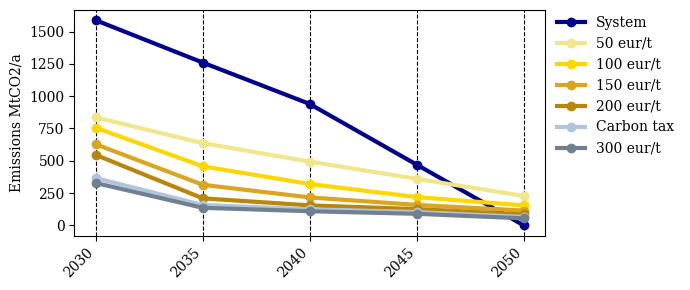

In [20]:
emisens = GDX_main['EMI_YCRAG']
emisens.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
ccsens = GDX_main['CC_YCRAG']
ccsens.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
#other = ["DUMMY", "HEAT", "LNG", "OTHERGAS", "PEAT", "RETORTGAS", "SHALE","WASTEHEAT"]
#oil = ["FUELOIL", "LIGHTOIL"]
biomass = ["BIOOIL", "STRAW", "WOOD", "WOODWASTE", "WOODCHIPS", "WOODPELLETS","BIOGAS"]
ccsens = ccsens[ccsens['Fuel'].isin(biomass)]
#emisens['Fuel'] = emisens['Fuel'].apply(lambda x: 'OTHER' if x in other else x)
#emisens['Fuel'] = emisens['Fuel'].apply(lambda x: 'OIL' if x in oil else x)
#emisens['Fuel'] = emisens['Fuel'].map(fuels).fillna(emisens['Fuel'])

#ccsens['Fuel'] = ccsens['Fuel'].apply(lambda x: 'BIOMASS-CCS' if x in biomass else x)
#ccsens['Fuel'] = ccsens['Fuel'].apply(lambda x: 'NATGAS-CCS' if x in ["NATGAS"] else x)
#ccsens['Fuel'] = ccsens['Fuel'].map(fuels).fillna(ccsens['Fuel'])



emisens_grouped = emisens.groupby(['Year','Scenario'])['Value'].sum().unstack() /1e3 # Mton
ccsens_grouped = ccsens.groupby(['Year','Scenario'])['Value'].sum().unstack() /-1e3 # Mton
#emi_cc_combined = pd.concat([emisens_grouped, ccsens_grouped], axis=1)
#emi_cc_combined = emi_cc_combined.reindex(order_scenario, level=1)
#emi_cc_combined.rename(index=scenario_names, level=1, inplace=True)


emi_cc_combined = emisens_grouped.add(ccsens_grouped, fill_value=0)
emi_cc_combined = emi_cc_combined[order_scenario]
emi_cc_combined.rename(columns=scenario_names, level=0, inplace=True)

colors_scenario = [color_mapping2[scenario] for scenario in order_scenario]

fig, ax = plt.subplots(figsize=(7, 3))
emi_cc_combined.plot(kind='line', stacked=False, ax=ax, color=colors_scenario, marker='o',linewidth=3)
ax.legend(title='',bbox_to_anchor=(1, 1.03), loc='upper left', frameon=False, edgecolor='black', fontsize=10)
#ax.set_title('Objective Function', fontsize=10)
ax.set_ylabel('Emissions MtCO2/a')
#ax.tick_params(axis='x', labelsize=8)
#ax.axhline(y=0, color='black', linewidth=0.8, zorder=0)
ax.set_xlabel('')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
# Add dashed lines for each 0.2 on the y-axis for the second chart
for x in np.arange(0, 5, 1):
    ax.axvline(x=x, color='black', linestyle='--', linewidth=0.8, zorder=0)
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
plt.tight_layout()
plt.show()

## dist sens

In [2]:
# Load GDX files
mainscenarios3 = ['syslim','natlim','natlimGDP','natlimPOP']

symbolBal3 = ['EMI_YCRAG']

gams_directory = 'C:\\GAMS\\46'
file_path = 'C:\\Users\\tmad\\GitHub\\pap01_code\\files'
GDX_main = gdx_to_dict(symbolBal3,mainscenarios3,gams_directory,file_path)

c:\Users\tmad\GitHub\pap01_code\Functions.py:35: UserWarning: The GAMS version (46.2.0) differs from the API version (48.1.0).
  ws = gams.GamsWorkspace(system_directory=gams_sys_dir)


Finished, making dictionary of dataframes.



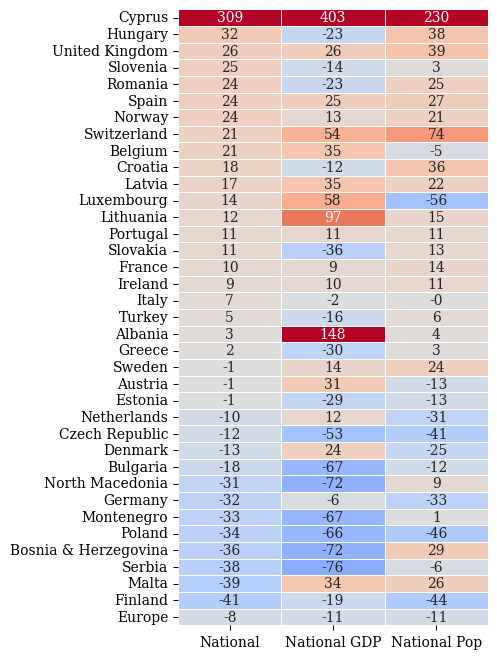

Scenario                National  National GDP  National Pop
Cyprus                309.115155    402.539052    229.955139
Hungary                31.891080    -23.135136     37.988546
United Kingdom         25.973714     26.046919     39.044626
Slovenia               24.649886    -13.537120      3.170385
Romania                23.866791    -22.578720     24.934653
Spain                  23.859790     25.286093     26.553605
Norway                 23.820002     12.569947     20.742404
Switzerland            21.486832     54.277421     74.191509
Belgium                20.845732     34.811821     -4.788499
Croatia                17.697085    -12.434114     35.806975
Latvia                 17.271449     34.999100     21.799220
Luxembourg             14.144607     58.234994    -55.965301
Lithuania              11.752655     97.440014     15.019467
Portugal               10.906247     11.295970     11.068734
Slovakia               10.711567    -35.788300     12.691145
France                  

In [52]:
import seaborn as sns

emi = GDX_main['EMI_YCRAG']
emi.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
emi = emi[(emi['Year']=='2030')]
emi_grouped = emi.groupby(['Country','Scenario'])['Value'].sum().unstack()*1e3
emi_grouped.rename(index=change_country_label, inplace=True)
emi_grouped_percent = emi_grouped.div(emi_grouped['syslim'], axis=0) - 1
emi_grouped_percent = emi_grouped_percent * 100
emi_grouped_total = emi_grouped.sum()
emi_grouped_total_percent = emi_grouped_total.div(emi_grouped_total['syslim'],axis=0) - 1
emi_grouped_total_percent = emi_grouped_total_percent * 100
emi_grouped_percent.drop(columns='syslim', inplace=True)
emi_grouped_total_percent.drop('syslim', inplace=True)
emi_grouped_percent.sort_values(by='natlim', ascending=False, inplace=True)
emi_grouped_percent_all = pd.concat([emi_grouped_percent, emi_grouped_total_percent.to_frame().T])
emi_grouped_percent_all.rename(index={0: 'Europe'}, inplace=True)
emi_grouped_percent_all.rename(columns={'natlim':'National','natlimGDP':'National GDP','natlimPOP':'National Pop'}, inplace=True)

plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(4, 8))
sns.heatmap(emi_grouped_percent_all, annot=True, cmap='coolwarm', center=0, vmax=150, vmin=-100, fmt=".0f", linewidths=.5,cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.show()
print(emi_grouped_percent_all)
